<h1>Distributed Federated Learning with MNIST Data</h1>

<b>Importing the libraries</b>

<ul>
<li> Pytorch (to train the model)
<li> Pysyft (to train using federated approach)
</ul>

In [16]:
import pickle
import itertools
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import syft as sy
from syft.frameworks.torch.fl import utils
import pandas as pd
import itertools
import random
import datetime

In [17]:
class Parser:
     def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 20
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False
        self.num_of_workers = 100
    
args = Parser()
torch.manual_seed(args.seed)
kwargs = {'num_workers': 1, 'pin_memory': False}

<b>Download MNIST Data using torchvision datasets module</b>

In [18]:
train_loader = DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    #.federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=1, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

<b>Creating architecture of the Neural Network model</b>

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.previous_accuracy = 0
        self.previous_params = {}

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def federated_avg(self, neighbour_model_params=None, current_worker=None):
        #Average two models weights
        
        
        
        params1 = self.state_dict()
        #print(self.previous_params, params1)
        params2 = neighbour_model_params #neighbour_model_params.copy()
      
        with torch.no_grad():
            for name1 in params1:
                if name1 in params2:
                    neighbour_ptr = params2[name1].copy()
                    neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                    params1[name1] = (params1[name1]  + neighbour_ptr)/2
        
                    
        self.load_state_dict(params1, strict=False)
        
    def federated_avg_multi(self, neighbour_model_params, current_worker=None):
        
        if len(neighbour_model_params) == 1:
            self.federated_avg(neighbour_model_params[0], current_worker)
        else:
            params1 = self.state_dict()
            for params2 in neighbour_model_params: 
                #params2 = neighbour_model_params #neighbour_model_params.copy()
                with torch.no_grad():
                    for name1 in params1:
                        if name1 in params2:
                            neighbour_ptr = params2[name1].copy()
                            neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                            params1[name1] = params1[name1]  + neighbour_ptr
            
            #Averaging model weights
            scale = len(neighbour_model_params) + 1
            with torch.no_grad():
                for name in params1:
                    #print("#######param  ", name)
                    params1[name] = params1[name] / scale
                
            #Load back new params to model        
            self.load_state_dict(params1, strict=False)
        
    def rollback_exchange(self):
        self.load_state_dict(self.previous_params, strict=False)
    

In [20]:
#Create events list for virutal workers exchange of parameters.
def create_events(num_of_workers):
    worker_events = list(itertools.combinations(range(1,num_of_workers+1),2))
    random.shuffle(worker_events)
    
    events_df = pd.DataFrame(worker_events,columns=['worker_id1','worker_id2'])
    events_df.index.names = ["batchnum"]
    return events_df

In [21]:
events_df = create_events(args.num_of_workers)
events_df

,worker_id1,worker_id2
batchnum,,
0,12,58
1,62,92
2,66,81
3,13,62
4,18,38
...,...,...
4945,63,83
4946,26,64
4947,10,45


<b>Initilizer Function to create Virtual workers, initiate models and optimizers. Data will split amongst workers and trained.</b>

In [22]:
def rotate_tuple_worker(worker_tuple):
    return worker_tuple[1:] + [worker_tuple[0]]

def generate_worker_split():
    target_worker_split = {}
    total_mnist_numbers = 10
    mnist_numbers = list(range(10))
    for i in range(args.num_of_workers):
        mnist_worker_number = random.sample(mnist_numbers, 3)
        
        for mnist_number in mnist_worker_number:
            if mnist_number in target_worker_split:
                target_worker_split[mnist_number].append(i)
            else:
                target_worker_split[mnist_number] = []
                target_worker_split[mnist_number].append(i)
    
    return target_worker_split
            
    
def initialize_workers():
    hook = sy.TorchHook(torch)
    compute_nodes = [sy.VirtualWorker(hook, id=f"worker-{i}") for i in range(args.num_of_workers)]
    remote_dataset = tuple(list() for _ in range(args.num_of_workers))
    input_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_counter = {}
    ##target_worker_split = {0:0, 1:1, 2:(2,0), 3:1, 4:0, 5:1, 6:2, 7:1, 8:(2,0), 9:2 }  ##target values for 3 workers
    #target_worker_split = {0:0, 1:1, 2:0, 3:1, 4:(1,0), 5:(1,0), 6:(0,1), 7:1, 8:(0,1), 9:0 }    ##target values for 2 workers
    #target_worker_split = {0:0, 1:1, 2:2, 3:0, 4:2, 5:1, 6:2, 7:0, 8:1, 9:2 }
    target_worker_split = generate_worker_split()
    print(target_worker_split)
    for batch_idx, (data,target) in enumerate(train_loader):
        target_value = target.item()
        
        if isinstance(target_worker_split[target_value], list):
            current_worker_idx = target_worker_split[target_value][0]
            target_worker_split[target_value] = rotate_tuple_worker(target_worker_split[target_value])
        else:
            current_worker_idx = target_worker_split[target_value]
        
        #for current_worker_idx in target_worker_split[target_value]:
        if len(target_worker_dataset[current_worker_idx]) == args.batch_size:
            input_data , target_values = list(zip(*target_worker_dataset[current_worker_idx]))
            target_values = torch.cat(target_values)
            input_data = torch.cat(input_data)
            remote_data = input_data.send(compute_nodes[current_worker_idx])
            remote_target = target_values.send(compute_nodes[current_worker_idx])
            remote_dataset[current_worker_idx].append((remote_data, remote_target))
            target_worker_dataset[current_worker_idx] = list()
                      
        target_worker_dataset[current_worker_idx].append((data, target))
            
        
    models = [Net() for _ in range(args.num_of_workers)]
    optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    return compute_nodes, remote_dataset, models, optimizers


In [23]:
def update(data, target, model, optimizer):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    return model

In [24]:
def check_accuracy(model, node):
    model.get()
    _, accuracy = test(model, node.id)
    return accuracy, model.send(node)

def exchange_parameters(models, data_index):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    event_idx = data_index % len(events_df)
    event_row = events_df.loc[[event_idx]]
    worker_id1 = event_row['worker_id1'].values[0]-1
    worker_id2 = event_row['worker_id2'].values[0]-1
    worker1_model = models[worker_id1]
    worker2_model = models[worker_id2]
    worker1_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
    worker2_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
    
    #Send worker2 params to worker1 for averaging at worker1
    #accuracy_before_exchange, models[worker_id1]  = check_accuracy(worker1_model, compute_nodes[worker_id1])
    
    worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
    accuracy_after_exchange, models[worker_id1]  = check_accuracy(worker1_model, compute_nodes[worker_id1])

    #print("#########Node - {} accuracy before exchange - {} ; accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[worker_id1], accuracy_before_exchange, accuracy_after_exchange, worker1_model.previous_accuracy ))
    
    if accuracy_after_exchange < worker1_model.previous_accuracy:
        worker1_model.rollback_exchange()
    else:
        worker1_model.previous_accuracy = accuracy_after_exchange
        worker1_model.previous_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
        
    
    #Send worker1 params to worker2 for averaging at worker2
    #accuracy_before_exchange, models[worker_id2]  = check_accuracy(worker2_model, compute_nodes[worker_id2])
    
    worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])
    #model_copy = worker2_model.copy()
    accuracy_after_exchange, models[worker_id2]  = check_accuracy(worker2_model, compute_nodes[worker_id2])
    #print("###########Node - {} accuracy before exchange - {} ;  accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[worker_id2], accuracy_before_exchange, accuracy_after_exchange, worker2_model.previous_accuracy ))
    if accuracy_after_exchange < worker2_model.previous_accuracy:
        worker2_model.rollback_exchange()
    else:
        worker2_model.previous_accuracy = accuracy_after_exchange
        worker2_model.previous_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
        
    return worker_id1, worker_id2

def exchange_parameters_all(models, data_index):
    exchange_combinations = list(itertools.combinations(range(len(models)), 2))
    random.shuffle(exchange_combinations)
    
    for worker_id1, worker_id2 in exchange_combinations:
        worker1_model = models[worker_id1]
        worker2_model = models[worker_id2]
        worker1_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
        worker2_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
        worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
        worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])
        
        

def exchange_parameters_multiple(models, data_index=None):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    #current_worker_idx = data_index % len(compute_nodes)
    #worker1_model = models[current_worker_idx]
    #worker1_params = worker1_model.state_dict().copy()
    worker_params = [model.state_dict().copy() for model in models]
    idx = 0
    
    for node in compute_nodes:
        other_worker_params = [param for i, param in enumerate(worker_params) if i != idx ]
        models[idx].federated_avg_multi(other_worker_params, compute_nodes[idx])
        idx += 1
    
        
    
    ##Copy the model to other workers
    #new_models = [] #[worker1_model.copy().move(node) for i, node in enumerate(compute_nodes) if i != current_worker_idx]
    #for i, node in enumerate(compute_nodes):
    #    if i == current_worker_idx:
    #        print("###CURRENT######", type(worker1_model), node, worker1_model)
    #        new_models.append(worker1_model)
    #    else:
    #        neighbour_model_ptr = worker1_model.copy()
    #        print("###other######", type(neighbour_model_ptr), node, worker1_model.location, neighbour_model_ptr)
    #        neighbour_model_ptr.move(node)
    #        new_models.append(neighbour_model_ptr)
    #        print("###After mive######", type(neighbour_model_ptr), node, neighbour_model_ptr)
    
    #return new_models
    
   

In [25]:
def train(models, compute_nodes, remote_dataset, optimizers, epoch_id, federated_average=False, decentralized=False):
    
    if federated_average:
        models = [models.copy() for _ in range(args.num_of_workers)]
        optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
        
    models = [model.send(compute_nodes[i]) for i, model in enumerate(models)]
    

    
    for remote_index in range(len(compute_nodes)):
        #print(f"Trip {data_index} and length of remote_dataset in {len(remote_dataset[0])} {len(remote_dataset[1])} {len(remote_dataset[2])}")
        for data_index in range(len(remote_dataset[remote_index])):
            data, target = remote_dataset[remote_index][data_index]
            models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])
        
    
       #Exchange of parameter between two remote models.
    if decentralized:
        #worker_id1, worker_id2 = exchange_parameters(models, epoch_id)
        exchange_parameters_all(models, epoch_id)
        #for i in range(len(models)):
        #    if i not in (worker_id1, worker_id2):
        #        print(i, worker_id1, worker_id2)
        #        accuracy, models[i] = check_accuracy(models[i], compute_nodes[i])
        #        if accuracy < models[i].previous_accuracy:
        #            models[i].rollback_exchange()
                
        #exchange_parameters_multiple(models, epoch_id)
        
        
    for i, model in enumerate(models):
        model.get()
        #if federated_average:
        #    _, current_accuracy = test(model, compute_nodes[i])
        #    print("###########Federated Average Node - {}  accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[i], current_accuracy, model.previous_accuracy ))
        #    model.previous_accuracy = current_accuracy
        
        
    
    #if exchange:
    #    return models
        
    #Federated Average
    if federated_average:
        model =  utils.federated_avg({f"worker-{i}":models[i] for i in range(len(compute_nodes))})
        return model

In [26]:
def test(federated_model, worker_id):
    federated_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = federated_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            prediction = output.argmax(1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()
           
        
    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)
    #print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_id, test_loss, avg_correct))
    return test_loss, avg_correct
    

In [27]:
def run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=False):
    model = Net()
    
    eval_results = []
    for epoch in range(args.epochs):
        start_time = time.time()
        print(f"Epoch Number {epoch + 1}")
        

        if decentralized:
            #models = train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_node.id, avg_loss, avg_accuracy))
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
        elif federated_average:
            
            federated_model = train(model, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            avg_loss, avg_accuracy = test(federated_model, "federated_avg_local")
            print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format("federated_avg_local", avg_loss, avg_accuracy))
            results = {"worker_id" : "federated_avg_local",
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
            eval_results.append(results)
            model = federated_model
        else:
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_node.id, avg_loss, avg_accuracy))
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
            
        total_time = time.time() - start_time
        print('Communication time over the network', round(total_time, 2), 's\n')
    return eval_results

###  Simulation with training on individual workers on their local data

In [28]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
individual_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-03-24 23:13:04.030751
{0: [0, 2, 7, 8, 12, 17, 19, 20, 22, 26, 28, 34, 41, 44, 45, 47, 49, 55, 65, 76, 77, 78, 88, 90, 92], 5: [0, 7, 9, 10, 12, 14, 16, 21, 25, 29, 30, 39, 42, 43, 44, 47, 50, 52, 57, 60, 63, 64, 69, 72, 73, 76, 79, 82, 86, 87, 92, 93, 96, 97, 99], 9: [0, 7, 11, 25, 28, 30, 33, 46, 52, 53, 54, 56, 64, 67, 69, 70, 72, 73, 74, 89, 90, 91, 92, 95, 96], 7: [1, 2, 5, 6, 15, 21, 24, 31, 33, 35, 36, 39, 40, 41, 43, 46, 51, 53, 56, 58, 60, 61, 71, 91, 93, 94], 1: [1, 4, 8, 10, 13, 16, 22, 25, 26, 27, 32, 34, 35, 37, 40, 44, 46, 48, 57, 58, 64, 66, 70, 71, 76, 81, 87, 98], 3: [1, 2, 3, 6, 9, 11, 22, 23, 24, 27, 28, 31, 32, 36, 38, 39, 43, 49, 50, 62, 63, 66, 67, 68, 71, 73, 74, 75, 79, 80, 81, 83, 85, 89, 94], 8: [3, 4, 5, 10, 11, 12, 14, 17, 26, 27, 29, 30, 34, 37, 38, 45, 48, 49, 51, 54, 55, 59, 61, 62, 67, 68, 69, 78, 80, 83, 84], 6: [3, 6, 8, 15, 17, 18, 19, 20, 21, 24, 29, 33, 38, 42, 48, 50, 53, 56, 57, 58, 59, 60, 61, 62, 63, 75, 77, 79, 80, 81, 82, 84, 8

Test set for worker worker-87: Average loss: 2.4801 & Average Accuracy : 0.1135
Test set for worker worker-88: Average loss: 2.5473 & Average Accuracy : 0.0983
Test set for worker worker-89: Average loss: 2.4318 & Average Accuracy : 0.1009
Test set for worker worker-90: Average loss: 2.7001 & Average Accuracy : 0.1037
Test set for worker worker-91: Average loss: 2.5271 & Average Accuracy : 0.1304
Test set for worker worker-92: Average loss: 2.4337 & Average Accuracy : 0.1747
Test set for worker worker-93: Average loss: 2.4163 & Average Accuracy : 0.1032
Test set for worker worker-94: Average loss: 2.5995 & Average Accuracy : 0.1028
Test set for worker worker-95: Average loss: 2.6697 & Average Accuracy : 0.1266
Test set for worker worker-96: Average loss: 2.3639 & Average Accuracy : 0.1009
Test set for worker worker-97: Average loss: 2.4523 & Average Accuracy : 0.1032
Test set for worker worker-98: Average loss: 2.4375 & Average Accuracy : 0.1743
Test set for worker worker-99: Average l

Test set for worker worker-89: Average loss: 3.2305 & Average Accuracy : 0.1439
Test set for worker worker-90: Average loss: 3.8631 & Average Accuracy : 0.2894
Test set for worker worker-91: Average loss: 3.5015 & Average Accuracy : 0.1853
Test set for worker worker-92: Average loss: 3.2678 & Average Accuracy : 0.1926
Test set for worker worker-93: Average loss: 3.3129 & Average Accuracy : 0.1682
Test set for worker worker-94: Average loss: 3.4371 & Average Accuracy : 0.1469
Test set for worker worker-95: Average loss: 3.6729 & Average Accuracy : 0.1977
Test set for worker worker-96: Average loss: 2.8603 & Average Accuracy : 0.1009
Test set for worker worker-97: Average loss: 3.1930 & Average Accuracy : 0.1032
Test set for worker worker-98: Average loss: 3.3241 & Average Accuracy : 0.2628
Test set for worker worker-99: Average loss: 3.6348 & Average Accuracy : 0.1795
Communication time over the network 485.33 s

Epoch Number 3
Test set for worker worker-0: Average loss: 4.3767 & Averag

Test set for worker worker-91: Average loss: 4.2383 & Average Accuracy : 0.2077
Test set for worker worker-92: Average loss: 3.9822 & Average Accuracy : 0.1933
Test set for worker worker-93: Average loss: 4.1588 & Average Accuracy : 0.2016
Test set for worker worker-94: Average loss: 4.1152 & Average Accuracy : 0.2666
Test set for worker worker-95: Average loss: 4.3987 & Average Accuracy : 0.2533
Test set for worker worker-96: Average loss: 3.5452 & Average Accuracy : 0.1017
Test set for worker worker-97: Average loss: 3.9328 & Average Accuracy : 0.1418
Test set for worker worker-98: Average loss: 4.1389 & Average Accuracy : 0.2865
Test set for worker worker-99: Average loss: 4.3714 & Average Accuracy : 0.2506
Communication time over the network 487.03 s

Epoch Number 4
Test set for worker worker-0: Average loss: 5.0060 & Average Accuracy : 0.2594
Test set for worker worker-1: Average loss: 5.4413 & Average Accuracy : 0.3013
Test set for worker worker-2: Average loss: 4.9898 & Average 

Test set for worker worker-93: Average loss: 4.8425 & Average Accuracy : 0.2458
Test set for worker worker-94: Average loss: 4.6399 & Average Accuracy : 0.2859
Test set for worker worker-95: Average loss: 4.9572 & Average Accuracy : 0.2729
Test set for worker worker-96: Average loss: 4.0969 & Average Accuracy : 0.1451
Test set for worker worker-97: Average loss: 4.5261 & Average Accuracy : 0.2371
Test set for worker worker-98: Average loss: 4.7475 & Average Accuracy : 0.2899
Test set for worker worker-99: Average loss: 4.9545 & Average Accuracy : 0.2690
Communication time over the network 491.61 s

Epoch Number 5
Test set for worker worker-0: Average loss: 5.5160 & Average Accuracy : 0.2634
Test set for worker worker-1: Average loss: 6.0025 & Average Accuracy : 0.3030
Test set for worker worker-2: Average loss: 5.5017 & Average Accuracy : 0.2941
Test set for worker worker-3: Average loss: 5.2084 & Average Accuracy : 0.2044
Test set for worker worker-4: Average loss: 5.2003 & Average Ac

Test set for worker worker-95: Average loss: 5.4118 & Average Accuracy : 0.2772
Test set for worker worker-96: Average loss: 4.5275 & Average Accuracy : 0.1946
Test set for worker worker-97: Average loss: 5.0397 & Average Accuracy : 0.2627
Test set for worker worker-98: Average loss: 5.2383 & Average Accuracy : 0.2915
Test set for worker worker-99: Average loss: 5.4537 & Average Accuracy : 0.2740
Communication time over the network 484.75 s

Epoch Number 6
Test set for worker worker-0: Average loss: 5.9418 & Average Accuracy : 0.2657
Test set for worker worker-1: Average loss: 6.4546 & Average Accuracy : 0.3048
Test set for worker worker-2: Average loss: 5.9101 & Average Accuracy : 0.2945
Test set for worker worker-3: Average loss: 5.0885 & Average Accuracy : 0.2471
Test set for worker worker-4: Average loss: 5.7246 & Average Accuracy : 0.2886
Test set for worker worker-5: Average loss: 6.3143 & Average Accuracy : 0.2241
Test set for worker worker-6: Average loss: 5.4290 & Average Accu

Test set for worker worker-97: Average loss: 5.5131 & Average Accuracy : 0.2697
Test set for worker worker-98: Average loss: 5.6498 & Average Accuracy : 0.2921
Test set for worker worker-99: Average loss: 5.8841 & Average Accuracy : 0.2764
Communication time over the network 483.04 s

Epoch Number 7
Test set for worker worker-0: Average loss: 6.3008 & Average Accuracy : 0.2683
Test set for worker worker-1: Average loss: 6.8242 & Average Accuracy : 0.3057
Test set for worker worker-2: Average loss: 6.2438 & Average Accuracy : 0.2946
Test set for worker worker-3: Average loss: 5.2744 & Average Accuracy : 0.2565
Test set for worker worker-4: Average loss: 6.1922 & Average Accuracy : 0.2908
Test set for worker worker-5: Average loss: 5.8247 & Average Accuracy : 0.2833
Test set for worker worker-6: Average loss: 5.8026 & Average Accuracy : 0.2888
Test set for worker worker-7: Average loss: 6.0685 & Average Accuracy : 0.2699
Test set for worker worker-8: Average loss: 6.0311 & Average Accura

Test set for worker worker-99: Average loss: 6.2474 & Average Accuracy : 0.2774
Communication time over the network 483.31 s

Epoch Number 8
Test set for worker worker-0: Average loss: 6.6023 & Average Accuracy : 0.2701
Test set for worker worker-1: Average loss: 7.1312 & Average Accuracy : 0.3064
Test set for worker worker-2: Average loss: 6.5224 & Average Accuracy : 0.2948
Test set for worker worker-3: Average loss: 5.4535 & Average Accuracy : 0.2600
Test set for worker worker-4: Average loss: 6.6066 & Average Accuracy : 0.2932
Test set for worker worker-5: Average loss: 6.2431 & Average Accuracy : 0.2832
Test set for worker worker-6: Average loss: 6.1167 & Average Accuracy : 0.2890
Test set for worker worker-7: Average loss: 6.3677 & Average Accuracy : 0.2729
Test set for worker worker-8: Average loss: 6.2631 & Average Accuracy : 0.2978
Test set for worker worker-9: Average loss: 5.8862 & Average Accuracy : 0.2383
Test set for worker worker-10: Average loss: 6.8856 & Average Accurac

Test set for worker worker-1: Average loss: 7.3894 & Average Accuracy : 0.3066
Test set for worker worker-2: Average loss: 6.7591 & Average Accuracy : 0.2949
Test set for worker worker-3: Average loss: 5.6119 & Average Accuracy : 0.2642
Test set for worker worker-4: Average loss: 6.9735 & Average Accuracy : 0.2948
Test set for worker worker-5: Average loss: 6.5270 & Average Accuracy : 0.2839
Test set for worker worker-6: Average loss: 6.3831 & Average Accuracy : 0.2892
Test set for worker worker-7: Average loss: 6.6277 & Average Accuracy : 0.2742
Test set for worker worker-8: Average loss: 6.4590 & Average Accuracy : 0.2991
Test set for worker worker-9: Average loss: 6.1483 & Average Accuracy : 0.2423
Test set for worker worker-10: Average loss: 7.1430 & Average Accuracy : 0.2804
Test set for worker worker-11: Average loss: 5.8411 & Average Accuracy : 0.2760
Test set for worker worker-12: Average loss: 6.6242 & Average Accuracy : 0.2594
Test set for worker worker-13: Average loss: 8.07

Test set for worker worker-3: Average loss: 5.7768 & Average Accuracy : 0.2692
Test set for worker worker-4: Average loss: 7.2969 & Average Accuracy : 0.2955
Test set for worker worker-5: Average loss: 6.7785 & Average Accuracy : 0.2848
Test set for worker worker-6: Average loss: 6.6116 & Average Accuracy : 0.2896
Test set for worker worker-7: Average loss: 6.8532 & Average Accuracy : 0.2754
Test set for worker worker-8: Average loss: 6.6286 & Average Accuracy : 0.2997
Test set for worker worker-9: Average loss: 6.3657 & Average Accuracy : 0.2494
Test set for worker worker-10: Average loss: 7.3642 & Average Accuracy : 0.2805
Test set for worker worker-11: Average loss: 6.1494 & Average Accuracy : 0.2770
Test set for worker worker-12: Average loss: 6.8413 & Average Accuracy : 0.2634
Test set for worker worker-13: Average loss: 8.3294 & Average Accuracy : 0.3069
Test set for worker worker-14: Average loss: 6.2170 & Average Accuracy : 0.2572
Test set for worker worker-15: Average loss: 6.

Test set for worker worker-5: Average loss: 6.9952 & Average Accuracy : 0.2855
Test set for worker worker-6: Average loss: 6.8106 & Average Accuracy : 0.2899
Test set for worker worker-7: Average loss: 7.0532 & Average Accuracy : 0.2762
Test set for worker worker-8: Average loss: 6.7779 & Average Accuracy : 0.3006
Test set for worker worker-9: Average loss: 6.5549 & Average Accuracy : 0.2524
Test set for worker worker-10: Average loss: 7.5698 & Average Accuracy : 0.2807
Test set for worker worker-11: Average loss: 6.3777 & Average Accuracy : 0.2788
Test set for worker worker-12: Average loss: 7.0326 & Average Accuracy : 0.2660
Test set for worker worker-13: Average loss: 8.5426 & Average Accuracy : 0.3069
Test set for worker worker-14: Average loss: 6.4173 & Average Accuracy : 0.2602
Test set for worker worker-15: Average loss: 6.9317 & Average Accuracy : 0.2862
Test set for worker worker-16: Average loss: 7.9268 & Average Accuracy : 0.2905
Test set for worker worker-17: Average loss: 

Test set for worker worker-7: Average loss: 7.2323 & Average Accuracy : 0.2770
Test set for worker worker-8: Average loss: 6.9111 & Average Accuracy : 0.3007
Test set for worker worker-9: Average loss: 6.6994 & Average Accuracy : 0.2581
Test set for worker worker-10: Average loss: 7.7551 & Average Accuracy : 0.2803
Test set for worker worker-11: Average loss: 6.6254 & Average Accuracy : 0.2774
Test set for worker worker-12: Average loss: 7.1936 & Average Accuracy : 0.2686
Test set for worker worker-13: Average loss: 8.7262 & Average Accuracy : 0.3068
Test set for worker worker-14: Average loss: 6.6034 & Average Accuracy : 0.2616
Test set for worker worker-15: Average loss: 7.1287 & Average Accuracy : 0.2866
Test set for worker worker-16: Average loss: 8.1305 & Average Accuracy : 0.2910
Test set for worker worker-17: Average loss: 6.8403 & Average Accuracy : 0.2807
Test set for worker worker-18: Average loss: 6.9141 & Average Accuracy : 0.2696
Test set for worker worker-19: Average loss

Test set for worker worker-9: Average loss: 6.8118 & Average Accuracy : 0.2606
Test set for worker worker-10: Average loss: 7.9252 & Average Accuracy : 0.2803
Test set for worker worker-11: Average loss: 6.8129 & Average Accuracy : 0.2778
Test set for worker worker-12: Average loss: 7.3347 & Average Accuracy : 0.2705
Test set for worker worker-13: Average loss: 8.8864 & Average Accuracy : 0.3070
Test set for worker worker-14: Average loss: 6.7747 & Average Accuracy : 0.2633
Test set for worker worker-15: Average loss: 7.3005 & Average Accuracy : 0.2869
Test set for worker worker-16: Average loss: 8.3165 & Average Accuracy : 0.2915
Test set for worker worker-17: Average loss: 7.0315 & Average Accuracy : 0.2813
Test set for worker worker-18: Average loss: 7.0366 & Average Accuracy : 0.2717
Test set for worker worker-19: Average loss: 7.0736 & Average Accuracy : 0.2817
Test set for worker worker-20: Average loss: 6.8718 & Average Accuracy : 0.2833
Test set for worker worker-21: Average lo

Test set for worker worker-11: Average loss: 6.9841 & Average Accuracy : 0.2775
Test set for worker worker-12: Average loss: 7.4603 & Average Accuracy : 0.2718
Test set for worker worker-13: Average loss: 9.0278 & Average Accuracy : 0.3072
Test set for worker worker-14: Average loss: 6.9320 & Average Accuracy : 0.2657
Test set for worker worker-15: Average loss: 7.4512 & Average Accuracy : 0.2873
Test set for worker worker-16: Average loss: 8.4867 & Average Accuracy : 0.2919
Test set for worker worker-17: Average loss: 7.2016 & Average Accuracy : 0.2818
Test set for worker worker-18: Average loss: 7.1491 & Average Accuracy : 0.2732
Test set for worker worker-19: Average loss: 7.2440 & Average Accuracy : 0.2824
Test set for worker worker-20: Average loss: 7.0065 & Average Accuracy : 0.2837
Test set for worker worker-21: Average loss: 7.9164 & Average Accuracy : 0.2740
Test set for worker worker-22: Average loss: 8.1204 & Average Accuracy : 0.3082
Test set for worker worker-23: Average l

Test set for worker worker-13: Average loss: 9.1532 & Average Accuracy : 0.3072
Test set for worker worker-14: Average loss: 7.0754 & Average Accuracy : 0.2662
Test set for worker worker-15: Average loss: 7.5857 & Average Accuracy : 0.2873
Test set for worker worker-16: Average loss: 8.6434 & Average Accuracy : 0.2921
Test set for worker worker-17: Average loss: 7.3534 & Average Accuracy : 0.2821
Test set for worker worker-18: Average loss: 7.2526 & Average Accuracy : 0.2753
Test set for worker worker-19: Average loss: 7.3994 & Average Accuracy : 0.2830
Test set for worker worker-20: Average loss: 7.1289 & Average Accuracy : 0.2843
Test set for worker worker-21: Average loss: 8.0584 & Average Accuracy : 0.2745
Test set for worker worker-22: Average loss: 8.2174 & Average Accuracy : 0.3085
Test set for worker worker-23: Average loss: 7.1797 & Average Accuracy : 0.2890
Test set for worker worker-24: Average loss: 7.7486 & Average Accuracy : 0.2921
Test set for worker worker-25: Average l

Test set for worker worker-15: Average loss: 7.7062 & Average Accuracy : 0.2878
Test set for worker worker-16: Average loss: 8.7883 & Average Accuracy : 0.2929
Test set for worker worker-17: Average loss: 7.4876 & Average Accuracy : 0.2825
Test set for worker worker-18: Average loss: 7.3488 & Average Accuracy : 0.2766
Test set for worker worker-19: Average loss: 7.5419 & Average Accuracy : 0.2834
Test set for worker worker-20: Average loss: 7.2413 & Average Accuracy : 0.2847
Test set for worker worker-21: Average loss: 8.1871 & Average Accuracy : 0.2750
Test set for worker worker-22: Average loss: 8.3044 & Average Accuracy : 0.3086
Test set for worker worker-23: Average loss: 7.2547 & Average Accuracy : 0.2892
Test set for worker worker-24: Average loss: 7.8748 & Average Accuracy : 0.2922
Test set for worker worker-25: Average loss: 10.0251 & Average Accuracy : 0.2967
Test set for worker worker-26: Average loss: 8.0322 & Average Accuracy : 0.3000
Test set for worker worker-27: Average 

Test set for worker worker-17: Average loss: 7.6066 & Average Accuracy : 0.2827
Test set for worker worker-18: Average loss: 7.4370 & Average Accuracy : 0.2781
Test set for worker worker-19: Average loss: 7.6728 & Average Accuracy : 0.2837
Test set for worker worker-20: Average loss: 7.3446 & Average Accuracy : 0.2847
Test set for worker worker-21: Average loss: 8.3042 & Average Accuracy : 0.2754
Test set for worker worker-22: Average loss: 8.3845 & Average Accuracy : 0.3086
Test set for worker worker-23: Average loss: 7.3244 & Average Accuracy : 0.2897
Test set for worker worker-24: Average loss: 7.9882 & Average Accuracy : 0.2923
Test set for worker worker-25: Average loss: 10.2074 & Average Accuracy : 0.2969
Test set for worker worker-26: Average loss: 8.1280 & Average Accuracy : 0.2998
Test set for worker worker-27: Average loss: 8.1303 & Average Accuracy : 0.2980
Test set for worker worker-28: Average loss: 7.4970 & Average Accuracy : 0.2938
Test set for worker worker-29: Average 

Test set for worker worker-19: Average loss: 7.7934 & Average Accuracy : 0.2839
Test set for worker worker-20: Average loss: 7.4409 & Average Accuracy : 0.2849
Test set for worker worker-21: Average loss: 8.4108 & Average Accuracy : 0.2756
Test set for worker worker-22: Average loss: 8.4574 & Average Accuracy : 0.3087
Test set for worker worker-23: Average loss: 7.3894 & Average Accuracy : 0.2900
Test set for worker worker-24: Average loss: 8.0912 & Average Accuracy : 0.2924
Test set for worker worker-25: Average loss: 10.3749 & Average Accuracy : 0.2970
Test set for worker worker-26: Average loss: 8.2153 & Average Accuracy : 0.3003
Test set for worker worker-27: Average loss: 8.2231 & Average Accuracy : 0.2981
Test set for worker worker-28: Average loss: 7.5854 & Average Accuracy : 0.2938
Test set for worker worker-29: Average loss: 6.8630 & Average Accuracy : 0.2657
Test set for worker worker-30: Average loss: 7.7823 & Average Accuracy : 0.2692
Test set for worker worker-31: Average 

Test set for worker worker-21: Average loss: 8.5089 & Average Accuracy : 0.2759
Test set for worker worker-22: Average loss: 8.5248 & Average Accuracy : 0.3087
Test set for worker worker-23: Average loss: 7.4508 & Average Accuracy : 0.2903
Test set for worker worker-24: Average loss: 8.1854 & Average Accuracy : 0.2925
Test set for worker worker-25: Average loss: 10.5301 & Average Accuracy : 0.2973
Test set for worker worker-26: Average loss: 8.2972 & Average Accuracy : 0.3007
Test set for worker worker-27: Average loss: 8.3086 & Average Accuracy : 0.2984
Test set for worker worker-28: Average loss: 7.6683 & Average Accuracy : 0.2937
Test set for worker worker-29: Average loss: 7.0223 & Average Accuracy : 0.2661
Test set for worker worker-30: Average loss: 7.9119 & Average Accuracy : 0.2697
Test set for worker worker-31: Average loss: 7.5601 & Average Accuracy : 0.2922
Test set for worker worker-32: Average loss: 9.0121 & Average Accuracy : 0.3087
Test set for worker worker-33: Average 

Test set for worker worker-23: Average loss: 7.5090 & Average Accuracy : 0.2905
Test set for worker worker-24: Average loss: 8.2730 & Average Accuracy : 0.2924
Test set for worker worker-25: Average loss: 10.6746 & Average Accuracy : 0.2973
Test set for worker worker-26: Average loss: 8.3722 & Average Accuracy : 0.3007
Test set for worker worker-27: Average loss: 8.3872 & Average Accuracy : 0.2987
Test set for worker worker-28: Average loss: 7.7468 & Average Accuracy : 0.2937
Test set for worker worker-29: Average loss: 7.1694 & Average Accuracy : 0.2664
Test set for worker worker-30: Average loss: 8.0273 & Average Accuracy : 0.2700
Test set for worker worker-31: Average loss: 7.6159 & Average Accuracy : 0.2928
Test set for worker worker-32: Average loss: 9.0918 & Average Accuracy : 0.3088
Test set for worker worker-33: Average loss: 7.2521 & Average Accuracy : 0.2889
Test set for worker worker-34: Average loss: 8.2556 & Average Accuracy : 0.3036
Test set for worker worker-35: Average 

###  Simulation with training  with federated average

In [29]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=True, decentralized=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-03-25 01:54:11.502019
{4: [0, 10, 11, 13, 14, 18, 20, 22, 30, 33, 38, 41, 42, 43, 48, 51, 52, 60, 61, 63, 64, 69, 71, 73, 75, 78, 82, 83, 84, 91, 93, 97, 98], 3: [0, 4, 5, 8, 9, 11, 13, 15, 17, 29, 36, 40, 44, 48, 51, 55, 56, 67, 79, 80, 81, 86], 7: [0, 1, 2, 3, 22, 23, 24, 29, 30, 32, 37, 38, 41, 42, 43, 46, 47, 58, 59, 62, 66, 68, 76, 78, 80, 81, 87, 90], 9: [1, 4, 10, 16, 28, 31, 35, 36, 42, 45, 46, 49, 52, 61, 62, 64, 65, 68, 69, 74, 76, 84, 86, 88, 92, 95, 96, 99], 5: [1, 6, 12, 14, 15, 17, 18, 21, 25, 26, 28, 31, 36, 37, 39, 40, 44, 48, 50, 52, 53, 54, 56, 57, 58, 59, 61, 65, 66, 69, 71, 72, 73, 88, 92, 94, 95], 1: [2, 3, 7, 8, 9, 18, 19, 23, 29, 34, 35, 40, 45, 47, 49, 53, 56, 60, 63, 65, 67, 74, 75, 77, 78, 79, 80, 83, 86, 89, 96, 98], 0: [2, 4, 6, 9, 12, 16, 21, 22, 23, 28, 30, 35, 38, 39, 50, 51, 55, 59, 64, 70, 76, 77, 85, 88, 90, 91, 93], 8: [3, 6, 7, 8, 19, 20, 21, 24, 27, 31, 33, 34, 37, 39, 41, 45, 50, 54, 57, 67, 70, 72, 74, 82, 85, 87, 89, 91, 94, 97, 9

###  Simulation with training  with Decentralized federated average

In [30]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
decentrailized_fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=True)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")  

Start time 2021-03-25 02:20:06.387983
{3: [0, 4, 5, 6, 7, 13, 15, 17, 18, 20, 26, 27, 29, 30, 33, 37, 38, 40, 42, 44, 47, 48, 50, 53, 54, 55, 60, 62, 63, 64, 67, 73, 80, 81, 82, 84, 86, 91, 92, 93, 97, 99], 6: [0, 2, 4, 19, 20, 22, 29, 32, 33, 35, 36, 39, 40, 42, 43, 46, 47, 49, 56, 57, 70, 72, 75, 79, 81, 82, 85, 88, 96, 97, 99], 0: [0, 6, 11, 12, 14, 23, 25, 33, 37, 49, 50, 51, 56, 58, 59, 60, 63, 66, 69, 73, 74, 76, 78, 79, 83, 85, 89, 91, 94, 95], 9: [1, 2, 3, 4, 10, 13, 15, 16, 17, 21, 24, 25, 30, 35, 36, 41, 42, 45, 48, 53, 60, 65, 68, 69, 72, 76, 77, 83, 86, 87, 96, 98], 2: [1, 7, 8, 9, 11, 13, 21, 28, 41, 52, 55, 57, 59, 61, 64, 65, 71, 75, 77, 81, 86, 88, 90, 91, 92, 93], 8: [1, 3, 8, 14, 19, 23, 26, 31, 34, 36, 37, 39, 48, 64, 65, 68, 74, 79, 87, 89, 90, 93, 96, 98], 4: [2, 5, 9, 10, 16, 18, 23, 24, 27, 29, 32, 34, 38, 39, 44, 45, 46, 56, 58, 61, 66, 67, 68, 70, 72, 76, 78, 80, 95, 98, 99], 5: [3, 5, 6, 7, 9, 12, 17, 26, 31, 32, 35, 38, 40, 41, 45, 49, 51, 52, 55, 57, 61, 67,

Test set for worker worker-87: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-88: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-89: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-90: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-91: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-92: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-93: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-94: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-95: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-96: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-97: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-98: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-99: Average l

Test set for worker worker-89: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-90: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-91: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-92: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-93: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-94: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-95: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-96: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-97: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-98: Average loss: 2.3025 & Average Accuracy : 0.0980
Test set for worker worker-99: Average loss: 2.3025 & Average Accuracy : 0.0980
Communication time over the network 864.42 s

Epoch Number 3
Test set for worker worker-0: Average loss: 2.3025 & Averag

Test set for worker worker-91: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-92: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-93: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3025 & Average Accuracy : 0.1135
Communication time over the network 863.66 s

Epoch Number 4
Test set for worker worker-0: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3025 & Average 

Test set for worker worker-93: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-94: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-95: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3025 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3025 & Average Accuracy : 0.1135
Communication time over the network 864.24 s

Epoch Number 5
Test set for worker worker-0: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3024 & Average Ac

Test set for worker worker-95: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-96: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-97: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3024 & Average Accuracy : 0.1135
Communication time over the network 863.75 s

Epoch Number 6
Test set for worker worker-0: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3024 & Average Accu

Test set for worker worker-97: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-98: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-99: Average loss: 2.3024 & Average Accuracy : 0.1135
Communication time over the network 863.95 s

Epoch Number 7
Test set for worker worker-0: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3024 & Average Accura

Test set for worker worker-99: Average loss: 2.3024 & Average Accuracy : 0.1135
Communication time over the network 875.79 s

Epoch Number 8
Test set for worker worker-0: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-1: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3024 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3024 & Average Accurac

Test set for worker worker-1: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-2: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-3: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.30

Test set for worker worker-3: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-4: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-5: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.

Test set for worker worker-5: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-6: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-7: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 

Test set for worker worker-7: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-8: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-9: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss

Test set for worker worker-9: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-10: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-11: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3023 & Average Accuracy : 0.1135
Test set for worker worker-21: Average lo

Test set for worker worker-11: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-12: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-13: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-23: Average l

Test set for worker worker-13: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-14: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-15: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-25: Average l

Test set for worker worker-15: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-16: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-17: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-27: Average l

Test set for worker worker-17: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-18: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-19: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-29: Average l

Test set for worker worker-19: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-20: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-21: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3022 & Average Accuracy : 0.1135
Test set for worker worker-31: Average l

Test set for worker worker-21: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-22: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-23: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-33: Average l

Test set for worker worker-23: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-24: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-25: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-26: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-27: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-28: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-29: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-30: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-31: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-32: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-33: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-34: Average loss: 2.3021 & Average Accuracy : 0.1135
Test set for worker worker-35: Average l

In [31]:
ind_train_df = pd.DataFrame(individual_train_results)
ind_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,2.495363,0.1676
1,worker-1,0,2.516493,0.1610
2,worker-2,0,2.472274,0.1895
3,worker-3,0,2.578021,0.1027
4,worker-4,0,2.361787,0.2246
...,...,...,...,...
1995,worker-95,19,7.754824,0.2930
1996,worker-96,19,7.283003,0.2739
1997,worker-97,19,8.481680,0.2781
1998,worker-98,19,8.206820,0.2993


In [32]:
fedavg_train_df = pd.DataFrame(fedavg_train_results)
fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,federated_avg_local,0,2.268158,0.1621
1,federated_avg_local,1,2.214985,0.3307
2,federated_avg_local,2,2.137632,0.4317
3,federated_avg_local,3,2.036066,0.5077
4,federated_avg_local,4,1.915324,0.5457
5,federated_avg_local,5,1.802198,0.5453
6,federated_avg_local,6,1.681685,0.6073
7,federated_avg_local,7,1.562378,0.6606
8,federated_avg_local,8,1.446885,0.6981
9,federated_avg_local,9,1.339595,0.7179


In [33]:
decentrailized_fedavg_train_df = pd.DataFrame(decentrailized_fedavg_train_results)
decentrailized_fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,2.302523,0.0980
1,worker-1,0,2.302523,0.0980
2,worker-2,0,2.302523,0.0980
3,worker-3,0,2.302523,0.0980
4,worker-4,0,2.302523,0.0980
...,...,...,...,...
1995,worker-95,19,2.302120,0.1135
1996,worker-96,19,2.302120,0.1135
1997,worker-97,19,2.302121,0.1135
1998,worker-98,19,2.302121,0.1135


### Plot Graph for Individual worker training accuracy over time.

In [34]:
#%matplotlib inline
#for key, grp in ind_train_df.groupby(['worker_id']):
#    grp.plot(x="epoch_idx", y="avg_accuracy", label=key, ylabel="avg_accuracy")



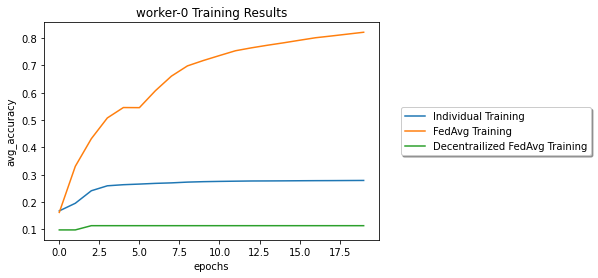

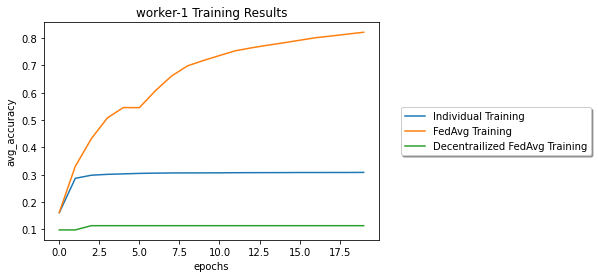

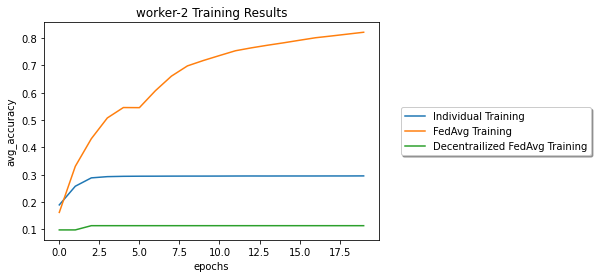

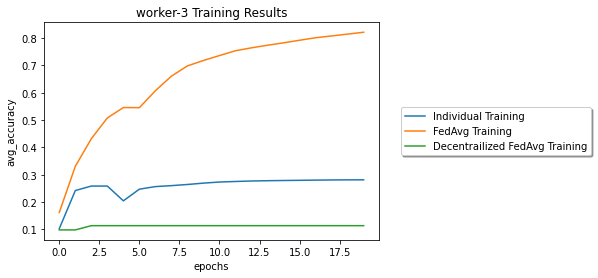

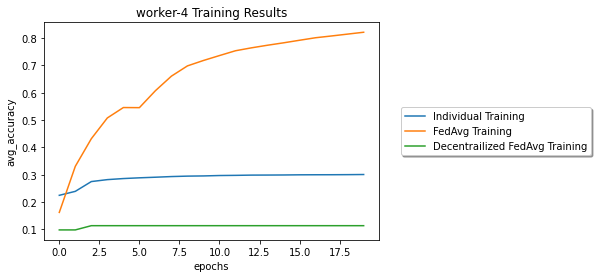

In [35]:
%matplotlib inline
ind_train_df
fedavg_train_df
decentrailized_fedavg_train_df
for node in compute_nodes[:5]:
    ind_worker_data  = ind_train_df[ind_train_df['worker_id']==node.id]
    plt.plot(ind_worker_data['epoch_idx'],ind_worker_data['avg_accuracy'], label="Individual Training")

    plt.plot(fedavg_train_df['epoch_idx'],fedavg_train_df['avg_accuracy'], label="FedAvg Training")
    
    decentral_worker_data  = decentrailized_fedavg_train_df[decentrailized_fedavg_train_df['worker_id']==node.id]
    plt.plot(decentral_worker_data['epoch_idx'],decentral_worker_data['avg_accuracy'], label="Decentrailized FedAvg Training")
    
    plt.xlabel('epochs')
    # Set the y axis label of the current axis.
    plt.ylabel('avg_accuracy')
    # Set a title of the current axes.
    plt.title(f'{node.id} Training Results')
    # show a legend on the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), shadow=True)
    # Display a figure.
    plt.show()